In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns

# 1 - Load Files

In [29]:
data_dir = '../data'

#Load data
hospital_latest = pd.read_csv(os.path.join(data_dir, 'donnees-hospitalieres-covid19-2020-05-05-19h00.csv'),
                              sep=';')

'''Util pour le SIER'''
tests_depistage_latest = pd.read_csv(os.path.join(data_dir, 'donnees-tests-covid19-labo-quotidien-2020-05-06-19h00.csv'),
                             sep=';')

#Load Metadata
age_metadata = pd.read_csv(os.path.join(data_dir, 'code-tranches-dage.csv'),
                              sep=';')

hospital_metadata = pd.read_csv(os.path.join(data_dir, 'metadonnees-donnees-hospitalieres-covid19.csv'),
                              sep=';')

gender_metadata = pd.read_csv(os.path.join(data_dir, 'metadonnees-sexe.csv'),
                              sep=';')

tests_depistage_metadata = pd.read_csv(os.path.join(data_dir, 'metadonnees-tests-depistage-covid19.csv'),
                              sep=';')


# 2 - Data discovery 

In [30]:
hospital_latest.shape

(14850, 7)

In [31]:
hospital_latest.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [32]:
hospital_metadata[['Colonne', 'Description_FR']]

,Colonne,Description_FR
0,dep,Département
1,sexe,Sexe
2,jour,Date de notification
3,hosp,Nombre de personnes actuellement hospitalisées
4,rea,Nombre de personnes actuellement en réanimatio...
5,rad,Nombre cumulé de personnes retournées à domicile
6,dc,Nombre cumulé de personnes décédées à l'hôpital


In [33]:
tests_depistage_latest.shape

(33330, 9)

In [34]:
tests_depistage_latest.head()

,dep,jour,clage_covid,nb_test,nb_pos,nb_test_h,nb_pos_h,nb_test_f,nb_pos_f
0,01,2020-03-10,0,0,0,0,0,0,0
1,01,2020-03-10,A,0,0,0,0,0,0
2,01,2020-03-10,B,0,0,0,0,0,0
3,01,2020-03-10,C,0,0,0,0,0,0
4,01,2020-03-10,D,0,0,0,0,0,0


In [35]:
tests_depistage_metadata[['Colonne', 'Description_FR']]

,Colonne,Description_FR
0,dep,Département
1,jour,Date de notification
2,clage_covid,Tranche d'âge des patients
3,nb_test,Nombre de tests pour recherche de SARS-CoV-2
4,nb_pos,Nombre de tests positifs pour recherche de SAR...
5,tx_pos,Taux de tests positif pour recherche de SARS-C...
6,nb_test_h,Nombre de tests pour recherche de SARS-CoV-2 -...
7,nb_pos_h,Nombre de tests positifs pour recherche de SAR...
8,nb_test_f,Nombre de tests pour recherche de SARS-CoV-2 -...
9,nb_pos_f,Nombre de tests positifs pour recherche de SAR...


In [36]:
age_metadata

,Code tranches d'age,Unnamed: 1
0,0,tous âges
1,A,moins de 15 ans
2,B,15-44 ans
3,C,45-64 ans
4,D,65-74 ans
5,E,75 et plus


In [37]:
gender_metadata

,Code,Sexe
0,0,femmes + hommes
1,1,hommes
2,2,femmes


In [38]:
hospital_latest.dtypes
#dep type object not int
#type date = object

dep     object
sexe     int64
jour    object
hosp     int64
rea      int64
rad      int64
dc       int64
dtype: object

In [39]:
#convert date
hospital_latest['jour'] =  pd.to_datetime(hospital_latest['jour'], format='%Y-%m-%d')
hospital_latest.dtypes

dep             object
sexe             int64
jour    datetime64[ns]
hosp             int64
rea              int64
rad              int64
dc               int64
dtype: object

In [40]:
dep_obj=pd.to_numeric(hospital_latest['dep'],errors='coerce').isnull()
hospital_latest[dep_obj]['dep'].unique()


array(['2A', '2B', nan], dtype=object)

In [41]:
tests_depistage_latest.dtypes
#dep type object not int
#type date = object

dep            object
jour           object
clage_covid    object
nb_test         int64
nb_pos          int64
nb_test_h       int64
nb_pos_h        int64
nb_test_f       int64
nb_pos_f        int64
dtype: object

In [61]:
#convert date
tests_depistage_latest['jour'] =  pd.to_datetime(tests_depistage_latest['jour'], format='%Y-%m-%d')
tests_depistage_latest.dtypes

dep                    object
jour           datetime64[ns]
clage_covid            object
nb_test                 int64
nb_pos                  int64
nb_test_h               int64
nb_pos_h                int64
nb_test_f               int64
nb_pos_f                int64
dtype: object

In [43]:
dep_obj=pd.to_numeric(tests_depistage_latest['dep'],errors='coerce').isnull()
tests_depistage_latest[dep_obj]['dep'].unique()

array(['2A', '2B'], dtype=object)

#  3- Analyse Data

In [ ]:
hospital_latest.describe()

,sexe,hosp,rea,rad,dc
count,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,1.000000,157.342357,31.414074,167.986465,55.095825
std,0.816524,300.362171,64.017471,335.232762,120.594982
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,3.000000,15.000000,3.000000
50%,1.000000,52.000000,10.000000,50.000000,14.000000
75%,2.000000,142.000000,29.000000,161.000000,47.000000
max,2.000000,3281.000000,855.000000,4341.000000,1542.000000


In [ ]:
tests_depistage_latest.describe()

,Nbre_pass_Corona,Nbre_pass_tot,Nbre_hospit_Corona,Nbre_acte_corona,Nbre_acte_tot
count,4884.000000,4884.000000,4884.000000,2208.000000,2208.000000
mean,53.308763,641.670147,21.668509,40.079710,405.353261
std,141.920431,997.559625,53.439205,94.967459,672.543136
min,0.000000,1.000000,0.000000,0.000000,4.000000
25%,2.000000,151.750000,0.000000,2.000000,75.000000
50%,13.000000,311.000000,4.000000,9.000000,176.500000
75%,48.000000,690.000000,20.000000,36.000000,445.250000
max,3598.000000,13483.000000,1073.000000,1563.000000,8074.000000


(-0.5, 2.5, -164.05, 3445.05)

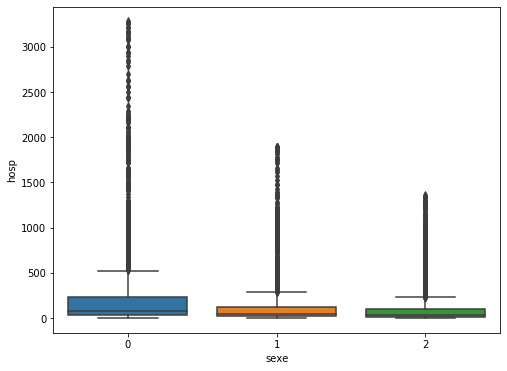

In [46]:
#box plot overallqual/saleprice
var = 'sexe'
data = pd.concat([hospital_latest['hosp'], hospital_latest[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="hosp", data=data)
fig.axis()

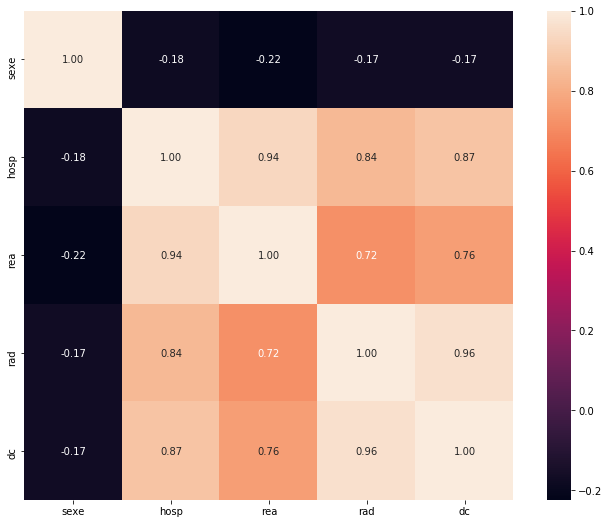

In [47]:
#correlation matrix
corrmat = hospital_latest.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

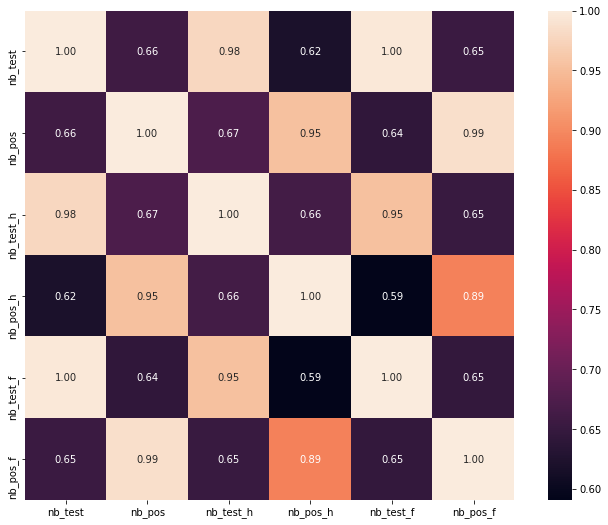

In [52]:
#correlation matrix
corrmat = tests_depistage_latest.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [48]:
aggr_hospital_latest=hospital_latest.groupby(['jour']).sum()
aggr_hospital_latest.drop(['sexe'],axis=1,inplace=True)
aggr_hospital_latest.index

DatetimeIndex(['2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
               '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05'],
              dtype='datetime64[ns]', name='jour', freq=None)

In [ ]:
tests_depistage_latest['nb_pos'])
plt.ylabel('nb_pos')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.show()

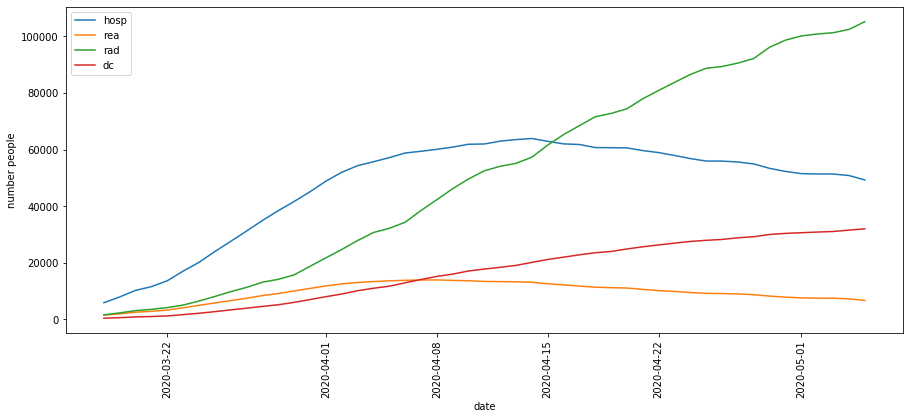

In [56]:
plt.figure(figsize=(15,6))
plt.plot(aggr_hospital_latest['hosp'])
plt.plot(aggr_hospital_latest['rea'])
plt.plot(aggr_hospital_latest['rad'])
plt.plot(aggr_hospital_latest['dc'])
plt.legend(aggr_hospital_latest)
plt.ylabel('number people')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.show()

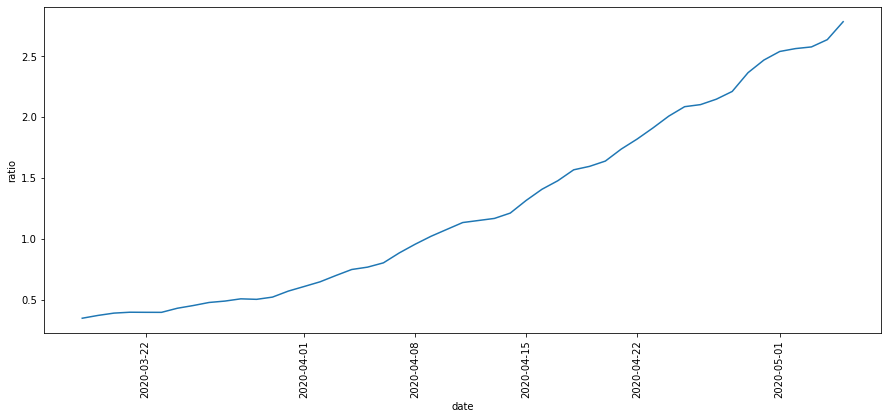

In [50]:
plt.figure(figsize=(15,6))
plt.plot((aggr_hospital_latest['rad']+aggr_hospital_latest['dc'])/aggr_hospital_latest['hosp'])
plt.ylabel('ratio')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.show()

In [69]:
aggr_tests_latest=tests_depistage_latest.groupby(['jour']).sum()
aggr_tests_latest.head()

,nb_test,nb_pos,nb_test_h,nb_pos_h,nb_test_f,nb_pos_f
jour,,,,,,
2020-03-10,156,16,76,14,80,2
2020-03-11,216,32,84,14,132,18
2020-03-12,311,66,156,42,155,24
2020-03-13,696,122,268,48,428,74
2020-03-14,332,108,146,46,186,62


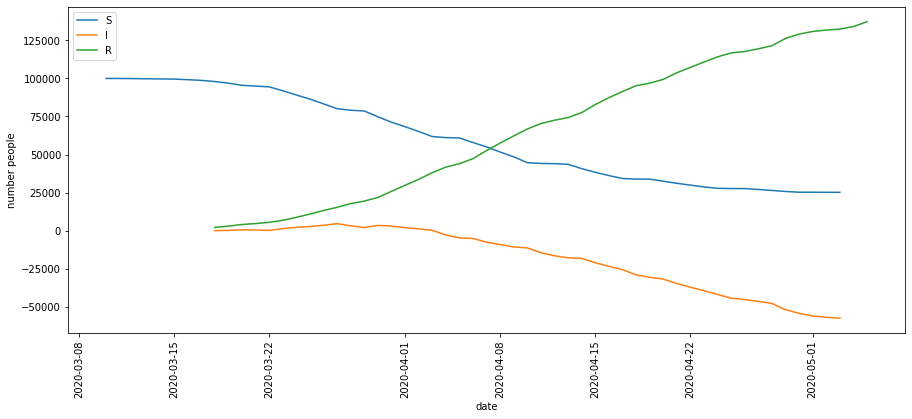

In [84]:
plt.figure(figsize=(15,6))
N=100000
plt.plot(N-aggr_tests_latest['nb_pos'].cumsum())
plt.plot(aggr_tests_latest['nb_pos'].cumsum()-aggr_hospital_latest['dc']-aggr_hospital_latest['rad'])
plt.plot(aggr_hospital_latest['dc']+aggr_hospital_latest['rad'])

plt.legend(['S','I','R'])
plt.ylabel('number people')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.show()

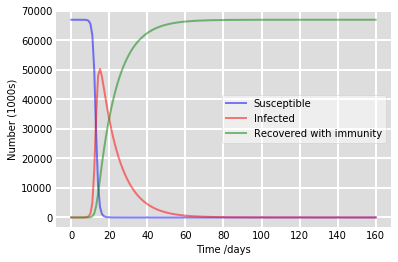

In [51]:


# Total population France, N.
N = 67000000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 1.5, 1./10 

# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()